In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TP1 - Panorámica

In [95]:
import cv2
import matplotlib.pyplot as plt

from utils import *

## 3.1 - Detección y descripción de características visuales

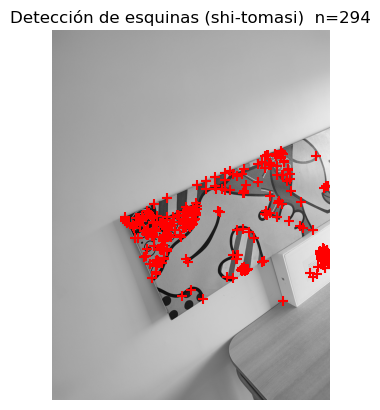

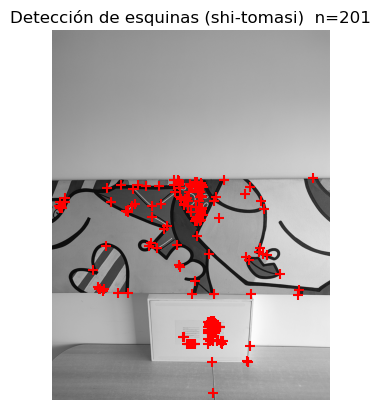

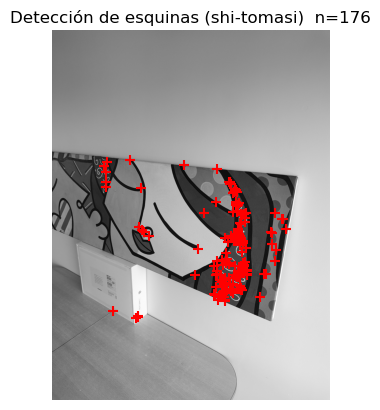

In [96]:
pathsC = ["img/cuadro_0.jpg", "img/cuadro_1.jpg", "img/cuadro_2.jpg"]

# --- 3.1: detectar y GUARDAR resultados (por ejemplo, con Shi-Tomasi) ---
corners_store = {}  # path -> dict con coords, responses, keypoints, img

for path in pathsC:
    img = cv2.imread(path)
    if img is None:
        print(f"No se pudo leer {path}"); continue

    # Visual (opcional)
    plot_corners(img, method='shi-tomasi', maxCorners=2000, qualityLevel=0.2, minDistance=8)

    # Guardar resultados de 3.1
# Tras tu 3.1:
    coordsu, responsesu, kpsu = find_corners(img, method='shi-tomasi',
                                    maxCorners=800, qualityLevel=0.2, minDistance=11)

    corners_store[path] = {"img": img, "coords": coordsu, "responses": responsesu, "kps": kpsu}


In [97]:
pathsU = ["img/udesa_0.jpg", "img/udesa_1.jpg", "img/udesa_2.jpg"]


# --- 3.1: detectar y GUARDAR resultados (por ejemplo, con Shi-Tomasi) ---
corners_storeU = {}  # path -> dict con coords, responses, keypoints, img

for path in pathsU:
    img = cv2.imread(path)
    if img is None:
        print(f"No se pudo leer {path}"); continue

    # Visual (opcional)
    plot_corners(img, method='shi-tomasi', maxCorners=2000, qualityLevel=0.2, minDistance=8)

    # Guardar resultados de 3.1
    coords, responses, kps = find_corners(img, method='shi-tomasi',
                                          maxCorners=2000, qualityLevel=0.2, minDistance=8)

    corners_storeU[path] = {"img": img, "coords": coords, "responses": responses, "kps": kps}

## 3.2 - Supresión de No Máxima Adaptativa

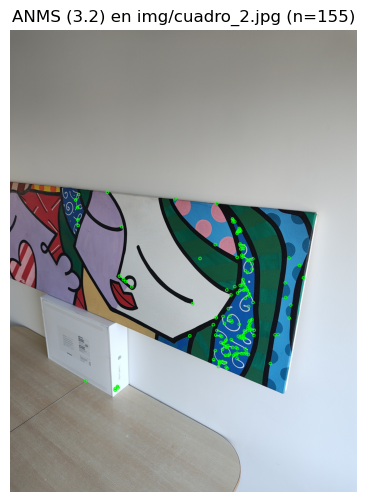

In [98]:
all_kps_anms_C = {}

for path, data in corners_store.items():
    img       = data["img"]
    coords    = data["coords"]
    responses = data["responses"]
    kps       = data["kps"]

    keep, Rk = anms_from_coords(coords, responses, N=500, strength_ratio=1.1)
    coords_anms = coords[keep]
    kps_anms    = [kps[i] for i in keep] 

    all_kps_anms_C[path] = {
        "img": img,
        "coords": coords_anms,
        "kps": kps_anms,
        "responses": responses[keep],
        "idx": keep,
        "radii": Rk
    }
       
    show_points_overlay(img, coords_anms, f"ANMS (3.2) en {path}")


In [99]:
all_kps_anms_U = {}

for path, data in corners_storeU.items():
    img       = data["img"]
    coords    = data["coords"]
    responses = data["responses"]
    kps       = data["kps"]

    keep, Rk = anms_from_coords(coords, responses, N=500, strength_ratio=1.1)
    coords_anms = coords[keep]
    kps_anms    = [kps[i] for i in keep] 

    all_kps_anms_U[path] = {
        "img": img,
        "coords": coords_anms,
        "kps": kps_anms,
        "responses": responses[keep],
        "idx": keep,
        "radii": Rk
    }
        
    show_points_overlay(img, coords_anms, f"ANMS (3.2) en {path}")

## 3.3 - Asociación de características 

img/cuadro_0.jpg: ANMS=265 puntos
img/cuadro_0.jpg: ORB.compute -> kps=263 desc=(263, 32)
img/cuadro_1.jpg: ANMS=173 puntos
img/cuadro_1.jpg: ORB.compute -> kps=173 desc=(173, 32)
img/cuadro_2.jpg: ANMS=155 puntos
img/cuadro_2.jpg: ORB.compute -> kps=155 desc=(155, 32)
img/cuadro_1.jpg ↔ img/cuadro_0.jpg  matches (ratio=0.85): 155


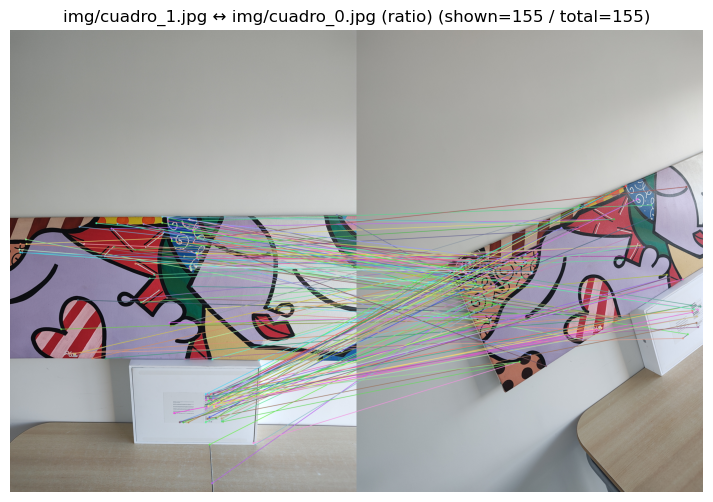

img/cuadro_1.jpg ↔ img/cuadro_0.jpg  matches (both, ratio=0.80): 59


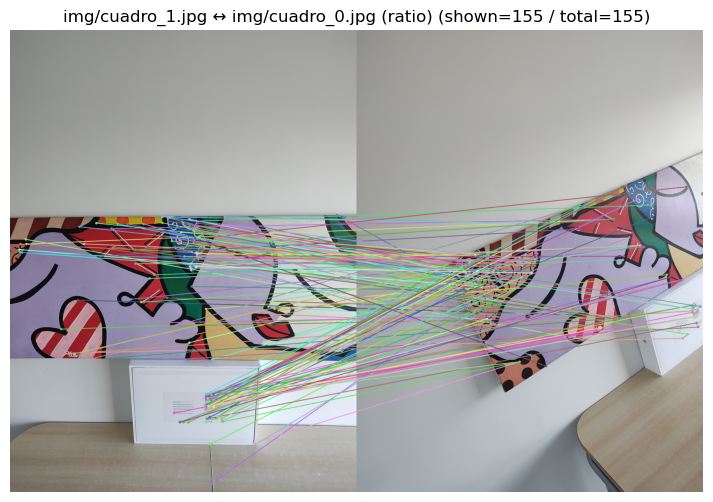

img/cuadro_1.jpg ↔ img/cuadro_2.jpg  matches (ratio=0.85): 160


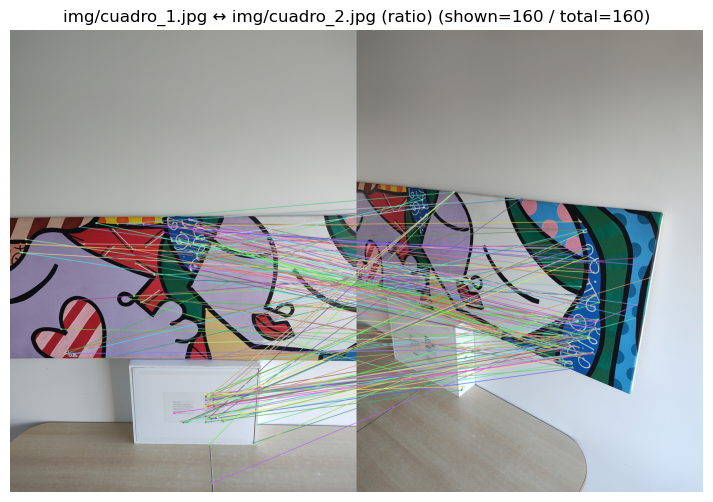

img/cuadro_1.jpg ↔ img/cuadro_2.jpg  matches (both, ratio=0.80): 55


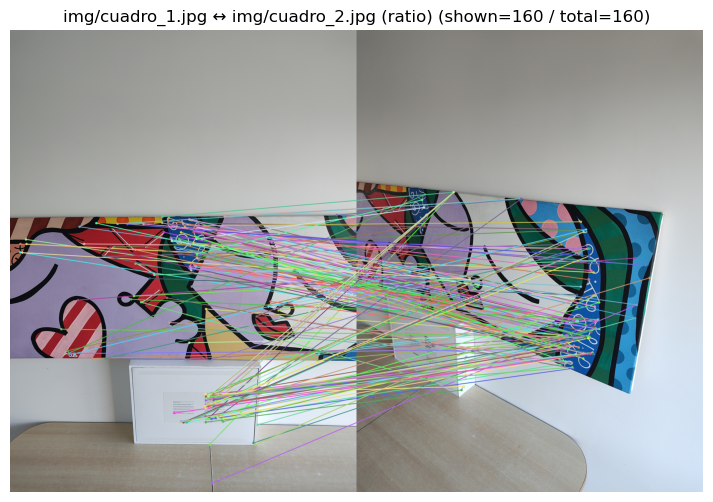

In [100]:
orb = build_orb()

features = {}
for path, d in all_kps_anms_C.items():      # <- tus puntos ANMS por imagen
    img = d["img"]
    coords = d["coords"]
    print(f"{path}: ANMS={len(coords)} puntos")
    kps2, desc = describe_orb_on_points(img, coords, orb=orb)
    print(f"{path}: ORB.compute -> kps={len(kps2)} desc={'None' if desc is None else desc.shape}")
    features[path] = {"img": img, "kps": kps2, "desc": desc}

# elegir ancla y matchear
anchor = pathsC[1]
for path in pathsC:
    if path == anchor: 
        continue
    A, B = features[anchor], features[path]
    if A["desc"] is None or B["desc"] is None or len(A["desc"])==0 or len(B["desc"])==0:
        print(f"[SKIP] sin descriptores en {path}")
        continue

    # 1) solo ratio (más laxo). Si sube mucho el ruido, probá policy="both".
    matches = match_orb(A["desc"], B["desc"], policy="ratio", ratio=1)
    print(f"{anchor} ↔ {path}  matches (ratio=0.85): {len(matches)}")
    draw_matches(A["img"], A["kps"], B["img"], B["kps"], matches,
                 title=f"{anchor} ↔ {path} (ratio)")

    # opcional: versión BOTH para comparar
    matches_both = match_orb(A["desc"], B["desc"], policy="both", ratio=1)
    print(f"{anchor} ↔ {path}  matches (both, ratio=0.80): {len(matches_both)}")
    draw_matches(A["img"], A["kps"], B["img"], B["kps"], matches,
                   max_lines=300, thickness=5, radius=7,
                   title=f"{anchor} ↔ {path} (ratio)")

img/udesa_0.jpg: ANMS=367 puntos
img/udesa_0.jpg: ORB.compute -> kps=364 desc=(364, 32)
img/udesa_1.jpg: ANMS=500 puntos
img/udesa_1.jpg: ORB.compute -> kps=496 desc=(496, 32)
img/udesa_2.jpg: ANMS=232 puntos
img/udesa_2.jpg: ORB.compute -> kps=229 desc=(229, 32)
img/udesa_1.jpg ↔ img/udesa_0.jpg  matches (ratio=0.85): 458


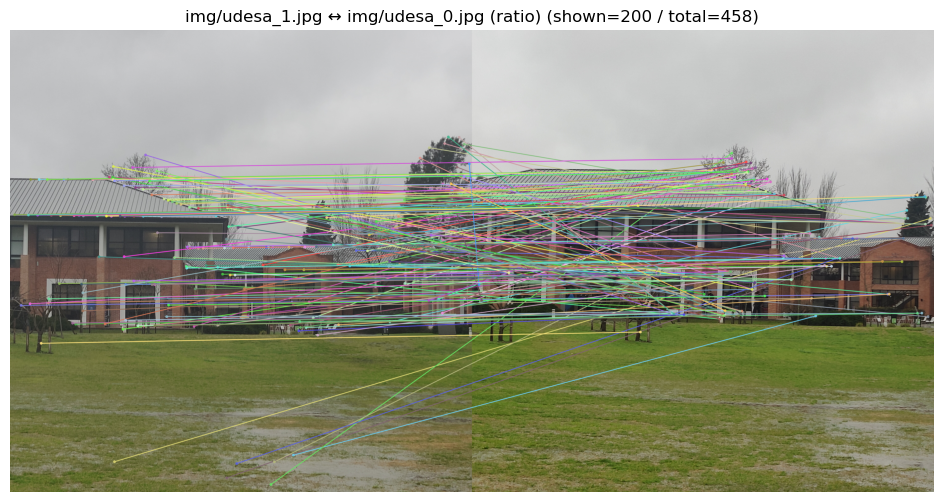

img/udesa_1.jpg ↔ img/udesa_0.jpg  matches (both, ratio=0.80): 131


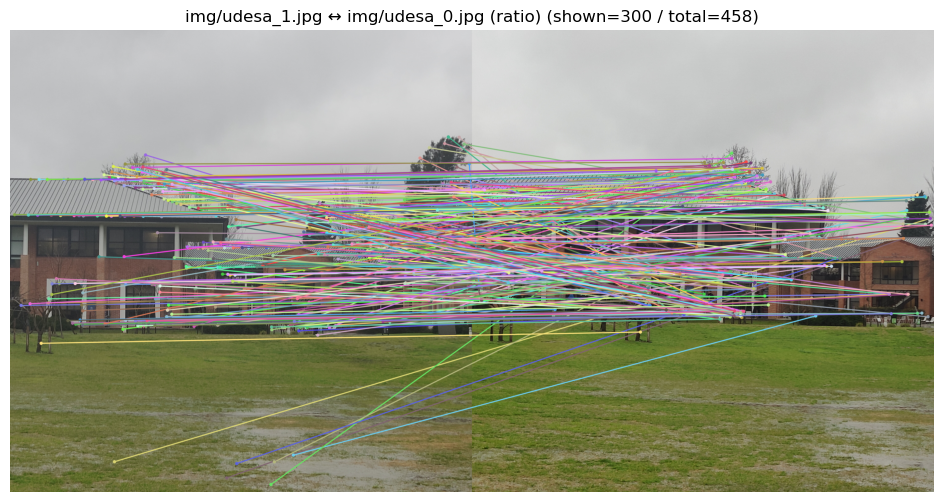

img/udesa_1.jpg ↔ img/udesa_2.jpg  matches (ratio=0.85): 456


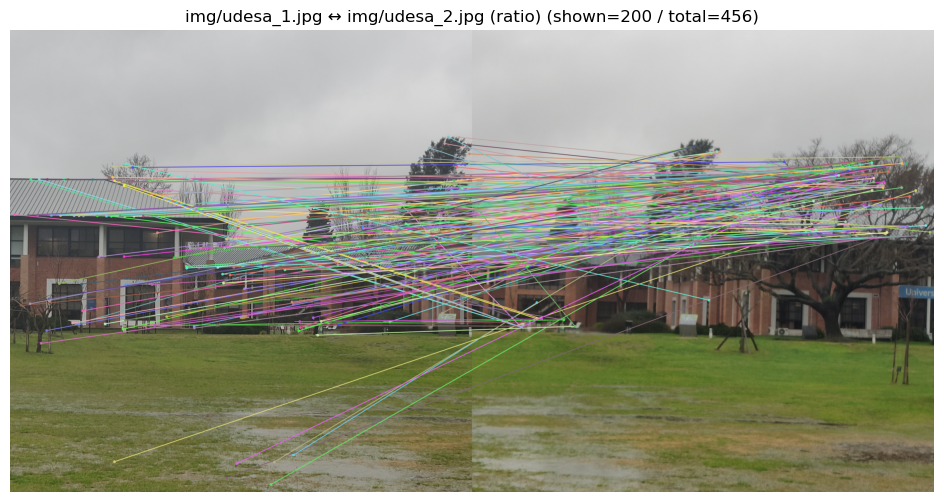

img/udesa_1.jpg ↔ img/udesa_2.jpg  matches (both, ratio=0.80): 73


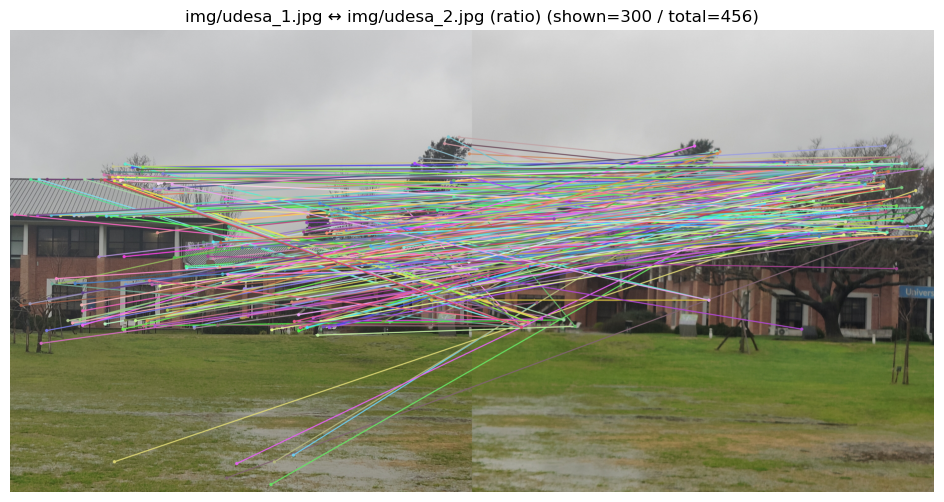

In [101]:
orb = build_orb()

features = {}
for path, d in all_kps_anms_U.items():      # <- tus puntos ANMS por imagen
    img = d["img"]
    coords = d["coords"]
    print(f"{path}: ANMS={len(coords)} puntos")
    kps2, desc = describe_orb_on_points(img, coords, orb=orb)
    print(f"{path}: ORB.compute -> kps={len(kps2)} desc={'None' if desc is None else desc.shape}")
    features[path] = {"img": img, "kps": kps2, "desc": desc}

# elegir ancla y matchear
anchor = pathsU[1]
for path in pathsU:
    if path == anchor: 
        continue
    A, B = features[anchor], features[path]
    if A["desc"] is None or B["desc"] is None or len(A["desc"])==0 or len(B["desc"])==0:
        print(f"[SKIP] sin descriptores en {path}")
        continue

    # 1) solo ratio (más laxo). Si sube mucho el ruido, probá policy="both".
    matches = match_orb(A["desc"], B["desc"], policy="ratio", ratio=1)
    print(f"{anchor} ↔ {path}  matches (ratio=0.85): {len(matches)}")
    draw_matches(A["img"], A["kps"], B["img"], B["kps"], matches,
                 title=f"{anchor} ↔ {path} (ratio)")

    # opcional: versión BOTH para comparar
    matches_both = match_orb(A["desc"], B["desc"], policy="both", ratio=1)
    print(f"{anchor} ↔ {path}  matches (both, ratio=0.80): {len(matches_both)}")
    draw_matches(A["img"], A["kps"], B["img"], B["kps"], matches,
                   max_lines=300, thickness=5, radius=7,
                   title=f"{anchor} ↔ {path} (ratio)")